In [729]:
import numpy as np  # array operations
import pandas as pd  # time series management
import matplotlib.pyplot as plt  # standard plotting library
from pylab import plt
plt.style.use('ggplot')
# put all plots in the notebook itself
%matplotlib inline


# Retrieving Data

In [730]:
symbol = 'AMZN.O'
data = pd.read_csv('https://hilpisch.com/tr_eikon_eod_data.csv',
                   index_col=0, parse_dates=True)[symbol].dropna()
data = pd.DataFrame(data)

In [731]:
data

,AMZN.O
Date,
2010-01-04,133.90
2010-01-05,134.69
2010-01-06,132.25
2010-01-07,130.00
2010-01-08,133.52
...,...
2018-06-25,1663.15
2018-06-26,1691.09
2018-06-27,1660.51


In [732]:
data.tail()  # the final five rows


,AMZN.O
Date,
2018-06-25,1663.15
2018-06-26,1691.09
2018-06-27,1660.51
2018-06-28,1701.45
2018-06-29,1699.80


# Generating Trading Signals
We want to implement a trading strategy based on simple moving averages (SMA). We work with two SMAs:
- short-term SMA over 42 days (SMA42)
- long-term SMA over 252 days (SMA252)

We distinguish two constellations:

- SMA42 > SMA252: buy signal, being long the market
- SMA42 < SMA252: sell signal, being short the market

We calculate the two SMAs as follows.

In [733]:
data['SMA42'] = data[symbol].rolling(window=1).mean()
data['SMA252'] = data[symbol].rolling(window=42).mean()
data.dropna(inplace=True)  # drop rows with NaN values

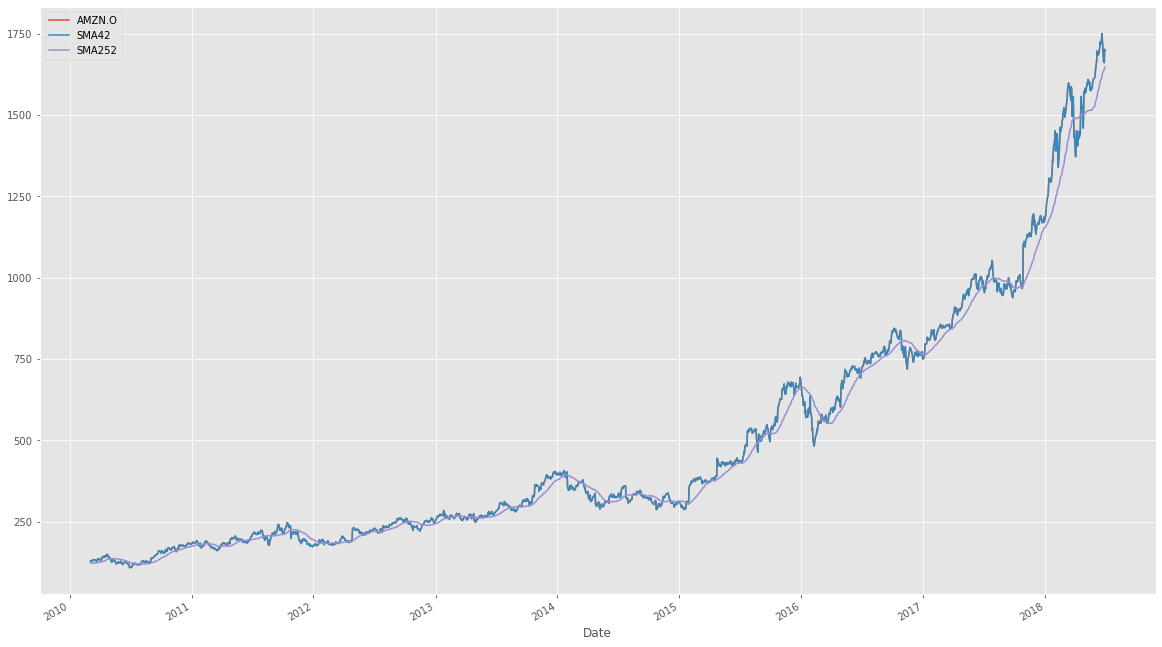

In [734]:
data[[symbol, 'SMA42', 'SMA252']].plot(figsize=(20, 12));

In [735]:
data[0:10]

,AMZN.O,SMA42,SMA252
Date,,,
2010-03-04,128.53,128.53,123.045905
2010-03-05,128.91,128.91,122.927095
2010-03-08,130.11,130.11,122.818048
2010-03-09,128.82,128.82,122.736381
2010-03-10,130.51,130.51,122.748524
2010-03-11,133.58,133.58,122.749952
2010-03-12,131.82,131.82,122.785952
2010-03-15,131.13,131.13,122.875952
2010-03-16,131.79,131.79,122.939762


In [736]:
# vectorized evaluation of the trading condition/signal generation
data['position'] = np.where(data['SMA42'] > data['SMA252'], 1, -1)
data[0:5]=0

In [737]:
pd.set_option('display.max_rows', 100)
print (data[0:100])

             AMZN.O    SMA42      SMA252  position
Date                                              
2010-03-04    0.000    0.000    0.000000         0
2010-03-05    0.000    0.000    0.000000         0
2010-03-08    0.000    0.000    0.000000         0
2010-03-09    0.000    0.000    0.000000         0
2010-03-10    0.000    0.000    0.000000         0
2010-03-11  133.580  133.580  122.749952         1
2010-03-12  131.820  131.820  122.785952         1
2010-03-15  131.130  131.130  122.875952         1
2010-03-16  131.790  131.790  122.939762         1
2010-03-17  131.340  131.340  123.034762         1
2010-03-18  132.760  132.760  123.168571         1
2010-03-19  130.350  130.350  123.233810         1
2010-03-22  130.470  130.470  123.345476         1
2010-03-23  129.260  129.260  123.408333         1
2010-03-24  128.040  128.040  123.565714         1
2010-03-25  134.730  134.730  123.909048         1
2010-03-26  135.060  135.060  124.280000         1
2010-03-29  135.120  135.120  1

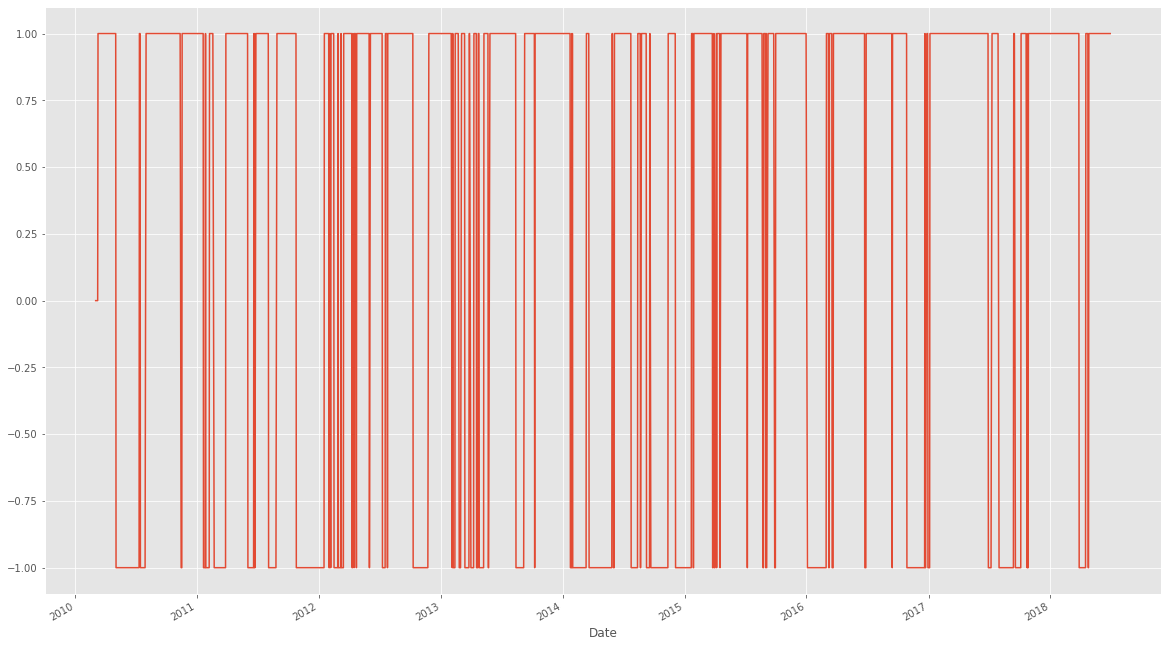

In [738]:
data['position'].plot(figsize=(20, 12))

# Backtesting = Judging Performance

Let us calculate the log returns as in the first module.
These are needed to judge the performance, i.e. to backtest, 
our SMA-based trading strategy. We call the column market since these are the market returns.

In [739]:
# vectorized calculation of log returns
data['market'] = np.log(data[symbol] / data[symbol].shift(1))

In [740]:
data[0:10]

,AMZN.O,SMA42,SMA252,position,market
Date,,,,,
2010-03-04,0.00,0.00,0.000000,0,NaN
2010-03-05,0.00,0.00,0.000000,0,NaN
2010-03-08,0.00,0.00,0.000000,0,NaN
2010-03-09,0.00,0.00,0.000000,0,NaN
2010-03-10,0.00,0.00,0.000000,0,NaN
2010-03-11,133.58,133.58,122.749952,1,inf
2010-03-12,131.82,131.82,122.785952,1,-0.013263
2010-03-15,131.13,131.13,122.875952,1,-0.005248
2010-03-16,131.79,131.79,122.939762,1,0.005021


Next, we can use the market returns to derive the strategy returns in vectorized fashion. Note the shift of the position column by one day, i.e. we have entered/maintained a position yesterday and and today's returns. It now becomes clear, why 1 represents a long position and -1 a short position: we get the market return when we are long and -1 times the market return when we are short. All this makes obviously a number of simplifying assumptions (e.g. no transaction costs).

In [741]:
# vectorized calculation of strategy returns
data['strategy'] = data['position'].shift(1) * data['market']

In [742]:
data.dropna(inplace=True)
data[0:100]


,AMZN.O,SMA42,SMA252,position,market,strategy
Date,,,,,,
2010-03-12,131.820,131.820,122.785952,1,-0.013263,-0.013263
2010-03-15,131.130,131.130,122.875952,1,-0.005248,-0.005248
2010-03-16,131.790,131.790,122.939762,1,0.005021,0.005021
2010-03-17,131.340,131.340,123.034762,1,-0.003420,-0.003420
2010-03-18,132.760,132.760,123.168571,1,0.010754,0.010754
2010-03-19,130.350,130.350,123.233810,1,-0.018320,-0.018320
2010-03-22,130.470,130.470,123.345476,1,0.000920,0.000920
2010-03-23,129.260,129.260,123.408333,1,-0.009317,-0.009317
2010-03-24,128.040,128.040,123.565714,1,-0.009483,-0.009483


In [743]:
# let us calculate the cumulative returns of the market vs. the trading strategy. 

In [744]:
data[['market', 'strategy']].cumsum().apply(np.exp) 

,market,strategy
Date,,
2010-03-12,0.986824,0.986824
2010-03-15,0.981659,0.981659
2010-03-16,0.986600,0.986600
2010-03-17,0.983231,0.983231
2010-03-18,0.993861,0.993861
...,...,...
2018-06-25,12.450591,1.176541
2018-06-26,12.659754,1.196306
2018-06-27,12.430828,1.174673


In [745]:
data.tail()


,AMZN.O,SMA42,SMA252,position,market,strategy
Date,,,,,,
2018-06-25,1663.15,1663.15,1634.929405,1,-0.031090,-0.031090
2018-06-26,1691.09,1691.09,1639.051548,1,0.016660,0.016660
2018-06-27,1660.51,1660.51,1641.144167,1,-0.018249,-0.018249
2018-06-28,1701.45,1701.45,1644.366071,1,0.024356,0.024356
2018-06-29,1699.80,1699.80,1647.164643,1,-0.000970,-0.000970


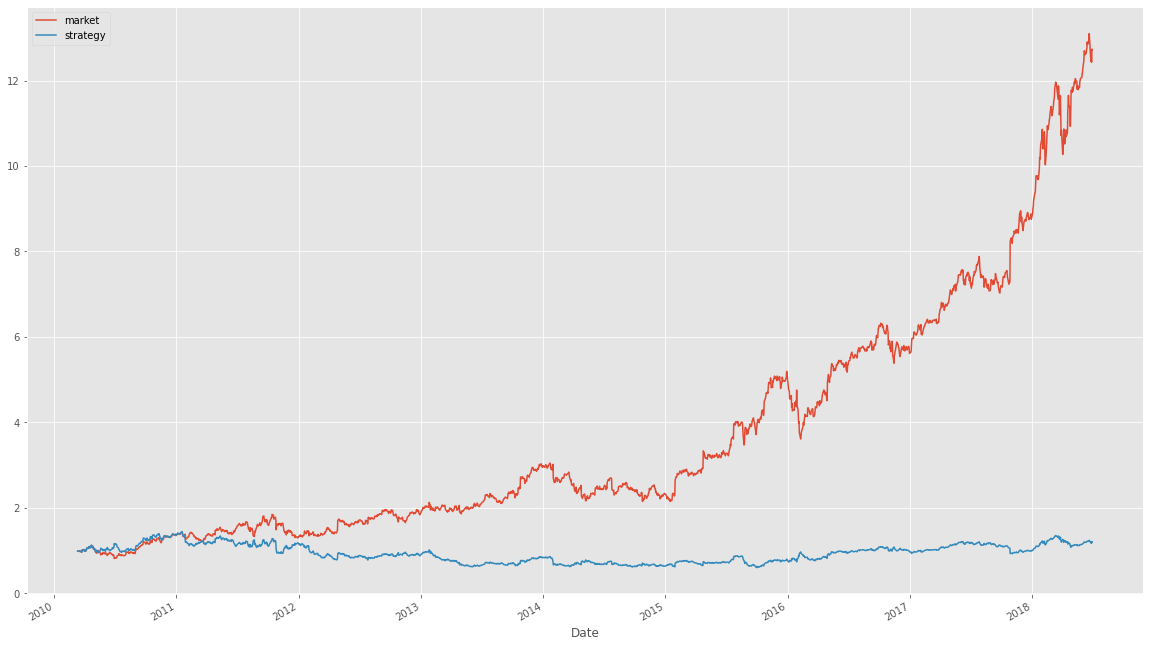

In [746]:
 data[['market', 'strategy']].cumsum().apply(np.exp).plot(figsize=(20, 12));


In [747]:
arets = data[['market', 'strategy']].mean() * 252  # annualized returns
arets


market      0.306542
strategy    0.022220
dtype: float64

In [748]:
astds = data[['market', 'strategy']].std() * 252 ** 0.5  # annualized volatility
astds

market      0.309166
strategy    0.309765
dtype: float64

In [749]:
print(np.log(2.718287) )

1.0000019025017868
